## Feature Selection | Cosmic Object Classification

The goal here is to get a preliminary idea of which fields might be predictive of 'class'.  We will start with a correlation matrix and some visualizations. 

#### Import Libraries & Setup Engines

In [22]:
from datetime import datetime as dt 
import numpy as np
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
import seaborn as sns

sql_engine = sql.create_engine('mssql+pyodbc://@localhost')

#### Read SQL table
Let's pull the Sloan Digital Sky Survey data that we got dummies for in the **get_dummies** notebook

In [23]:
table = 'STAR_CLASSIFICATION'

query = f"SELECT * FROM {table}"
df = pd.read_sql_query(query, sql_engine, index_col='obj_ID')
df.head()

,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID,GALAXY,QSO,STAR
obj_ID,,,,,,,,,,,,,,,,,,,,
1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171,1,0,0
1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427,1,0,0
1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299,1,0,0
1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775,1,0,0
1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842,1,0,0


#### Here's some information about what these columns represent
- obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
- alpha = Right Ascension angle (at J2000 epoch)
- delta = Declination angle (at J2000 epoch)
- u = Ultraviolet filter in the photometric system
- g = Green filter in the photometric system
- r = Red filter in the photometric system
- i = Near Infrared filter in the photometric system
- z = Infrared filter in the photometric system
- run_ID = Run Number used to identify the specific scan
- rereun_ID = Rerun Number to specify how the image was processed
- cam_col = Camera column to identify the scanline within the run
- field_ID = Field number to identify each field
- spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
- class = object class (galaxy, star or quasar object)
- redshift = redshift value based on the increase in wavelength
- plate = plate ID, identifies each plate in SDSS
- MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
- fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

We can drop irrelevant columns now

In [28]:
df.drop(columns=['run_ID', 'rerun_ID', 'cam_col', 'plate'], inplace=True) 

#### Produce a correlation matrix 
We will use Pandas' .corr() and Seaborn's heatmap(), and get rid of some irrelevant columns

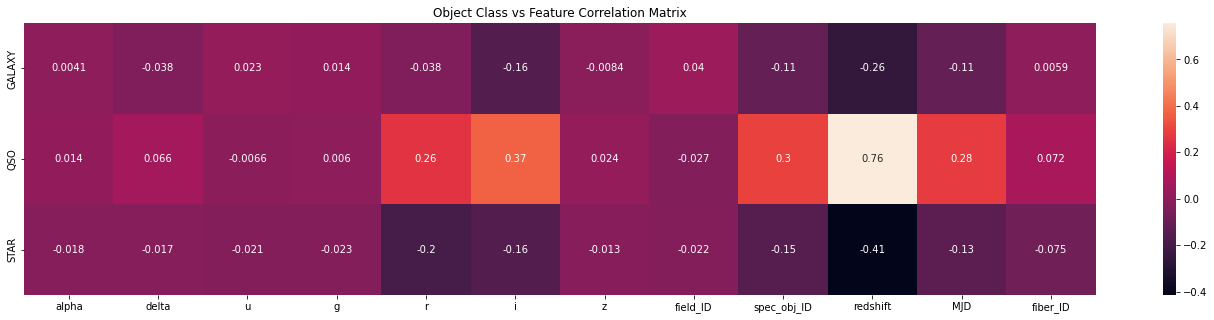

In [52]:
cm = df.corr().loc['GALAXY':'STAR', :'fiber_ID']

plt.figure(figsize=(24,5))
plt.title('Object Class vs Feature Correlation Matrix') 
sns.heatmap(cm, annot=True)
plt.show()

The type of filter used in the photometric system appears to be correlated with object class.  It is important to note that correlation should not be confused with causation.. as it is quite likely that the astonomers' choice of filter was impacted by object class, and not the other way around.  We also see that spectral object ID, redshift, and date are relatively correlated with class. Similar to the filters, the correlation on date is likely an artifact of the astronomers' behavior, i.e. they targeted different classes over different time periods.  We will attempt to control for these factors in our model. For now, we are pretty interested in how redshift interacts with object class. 

### Dig into redshift

It looks like there's some pretty good seperation judging by this boxplot

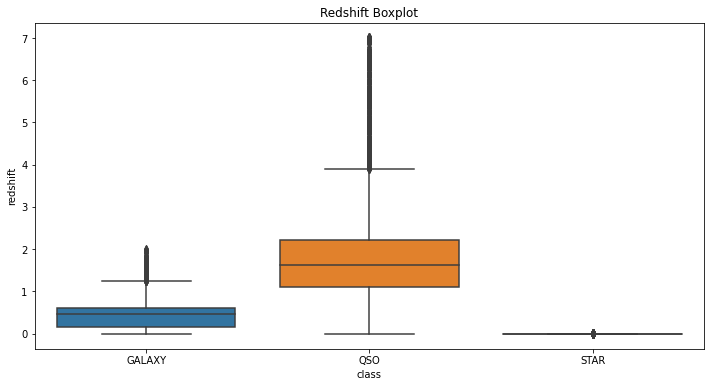

In [89]:
plt.figure(figsize=(12,6))
plt.title('Redshift Boxplot') 
sns.boxplot(x='class', y='redshift', data=df)
plt.show()

#### Look at how the data changes over time
We have the date, let's see if we can find any interesting trends in the timeseries 

In [86]:
def plot_time(ind_var, zero_y=False): 
    
    plt.figure(figsize=(18,9))
    plt.title(ind_var+' Timeseries') 
    sns.scatterplot(x='MJD', y=ind_var, hue='class', data=df)
    plt.xlim(51500,58500)
    if zero_y: plt.ylim(0,)
    plt.show()
    

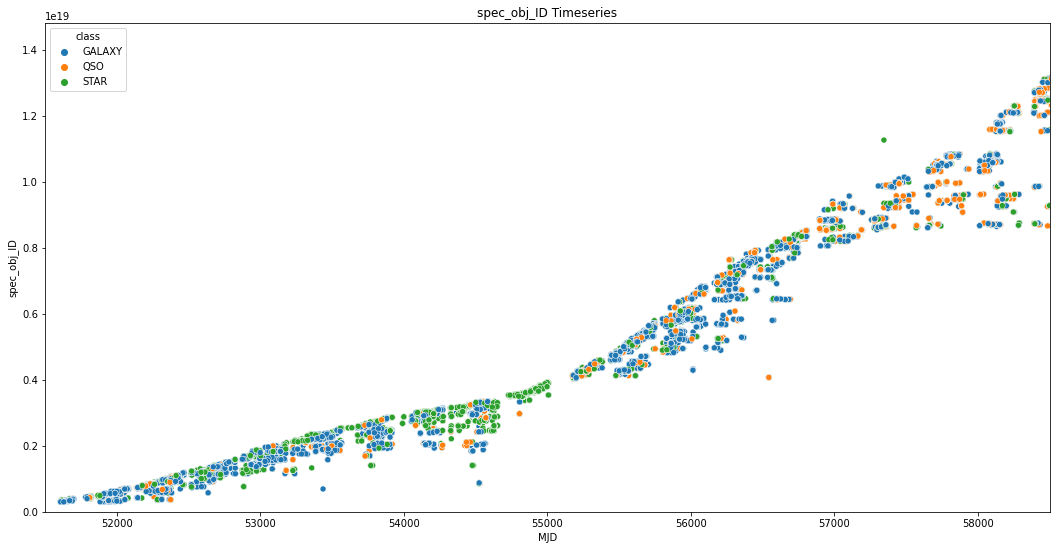

In [87]:
plot_time('spec_obj_ID', zero_y=True) 

There's a healthy mix of object class over time.  spec_obj_ID steadily increases over time, as expected. 

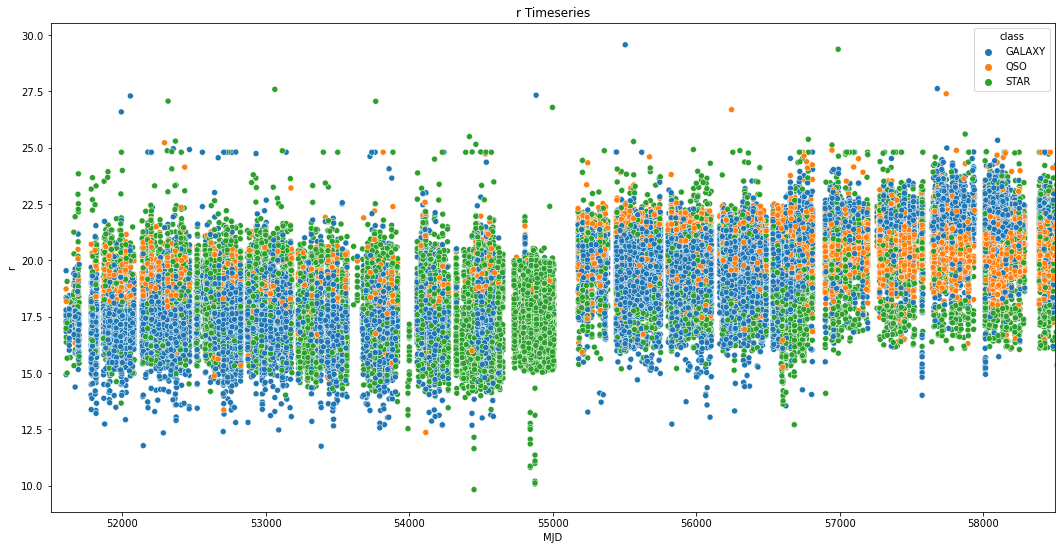

In [83]:
plot_time('r') 

We can see the interaction between class and r. It also looks like theres some shift in red filter usage in 2009.  It's easier to see there's some gap following roughly annual periodicity. 

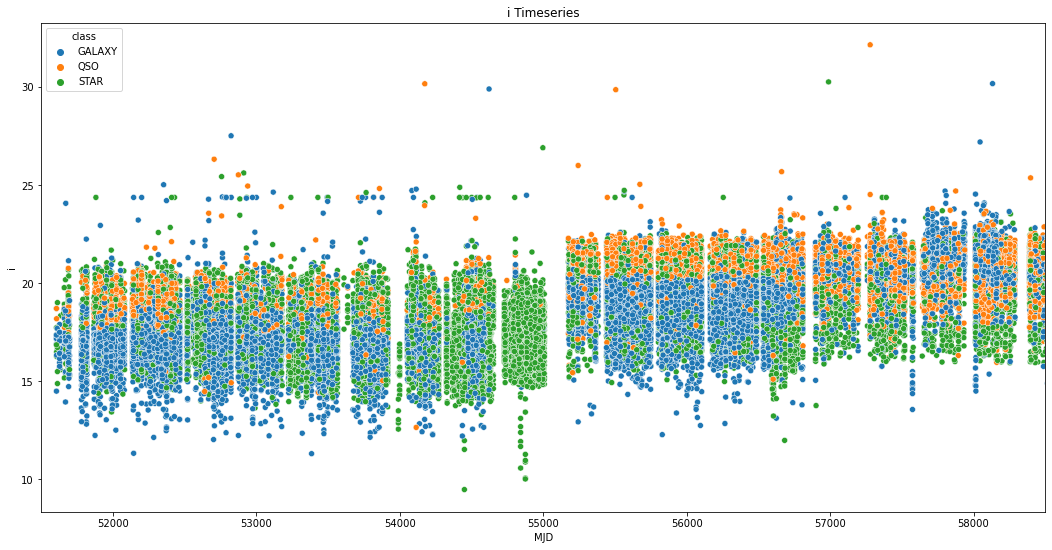

In [84]:
plot_time('i')

The near infrared filter looks very similar to the red filter.  This seems to be intuitive, but we'll see if our model can better parse these interactions. 

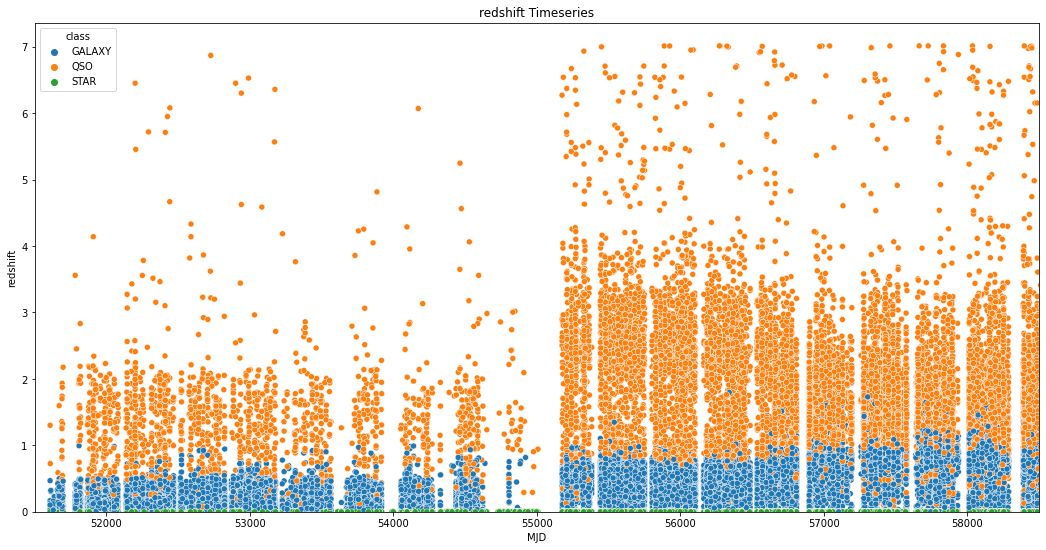

In [88]:
plot_time('redshift', zero_y=True)

Beautiful, we can see the classes super clear here.  It looks like there's much more volume after 2009, with some obvious higher redshifted quasars. 

#### Findings
We got a much better understanding of the data from this exploration.  Overall, we are primarily interested in redshift as a predictor of object class, and are more aware of how red filters and date interact with our other variables. We will take care to control for these secondary factors, while noting their causal limitations. It will be interesting to see what types of models are the most effective at predicting object class using this rough target set. 